#Lecture 11: Introduction to Unsupervised Learning

Unsupervised learning finds patterns in data.  Unlike supervised learning where you typically have a set of input-output pairs $\{ <X_i,y_i> \}$ or what is known as "labeled data", in unsupervised learning you just have a set of inputs $\{X_i\}$ and your goal is to learn something about them.  For instance, if $X \in R^N$ is a vector, there might be correlations between elements of $X$ so that the data live on a low-dimensional plane.  Or perhaps a surface.  Or maybe the data are organized in groups or clusters.  This can be very useful information to have.  It is particularly important if you are trying to do data compression, because the data may look complicated but in fact might come from a simple low-dimensional distribution.  In that case you could encode only the low-dimensional part of the data and use that for computation.  This is important in signal processing when you are faced with high-dimensional timeseries (like a video stream) and you need to extract something low-dimensional (like average image motion).  The trick to unsupervised learning is that you do not know in advance what the output will be used for, so you are trying to code the input in some way that might be universally useful.  Nothing is universally useful.  But preserving the ability to reconstruct the input is probably not bad to try.

From what I have just said, you might be getting the idea that there is a close relationship between unsupervised learning and data compression.  This is true, but only if the data compression is *optimal*.  If I compress a series of images by choosing the 10 pixels in the upper left corner, that is very poor compression because I am unlikely to be able to reconstruct the original images from that.  

In this lecture we are going to look primarily at linear data compression.  This means that if I have a vector input $x$, then I want to find a matrix $W$ such that $y=Wx$ "represents" $x$ well in some sense.  The sense that we will use is the ability to reconstruct $x$ from $y$.  If we can do that, then $y$ is a good representation of $x$.  Of course, we could just choose $W=I$ and get a perfect result.  But then we don't learn anything. The interesting case occurs when $y \in R^M$ while $x \in R^N$ and $N>M$.  In other words, $y$ is smaller than $x$, so perfect (linear) reconstruction is not possible.

##Linear compression networks
This leads to the basic structure $\hat{x} = Cy = CWx$ where $y=Wx$ is the linear encoder that compresses input $x$ onto output $y$, and then $C$ is a linear decoder that tries to reconstruct $x$.  In this case, we almost always use mean-squared error, so we attempt to minimize $E[(\hat{x}-x)^2]$.   The optimal solution is well-known; $W$ should span the space of the first $M$ eigenvectors of the autocorrelation $R_{xx}$ of $x$.  

Remember that eigenvectors are defined as 
\begin{equation}
  R_{xx}v_i = \lambda_i v_i
\end{equation}
where $\lambda_i$ is the scalar eigenvalue corresponding to eigenvector $x$, and because $R_{xx}$ is real and symmetric the eigenvalues are real.  For simplicity we almost always assume that eigenvectors are distinct but they do not have to be.  Assume $\lambda_0 > \lambda_1 > \ldots > \lambda_N$.  We can write any input as
\begin{equation}
  x = \sum_i \alpha_i(x) v_i
\end{equation}
which is the eigenvector decomposition.  The $\alpha_i$'s are the coefficients that mix the eigenvectors together. They depend on $x$ of course, because different $x$'s require different $\alpha_i(x)$'s. It is easy to calculate the $\alpha$'s:
\begin{equation}
  \alpha_i(x) = v_i^T x
\end{equation}
We also have 
\begin{equation}
  R_{xx} = \sum_i v_iv_i^T E[\alpha_i(x)^2] \\
    = \sum_i v_i v_i^T \lambda_i
\end{equation}
so we see that $\lambda_i = E[\alpha_i(x)^2]$. 

Suppose we want to find a scalar encoder $y=w^Tx$ for an encoder vector $w$, then we can find the eigenvector decomposition of $w$
\begin{equation}
  w = \sum_i \alpha_i(w) v_i
\end{equation}
which gives
\begin{equation}
  y=w^Tx = \sum_i \alpha_i(x)\alpha_i(w)
\end{equation}
because eigenvectors have the property that $v_i^Tv_j = 0$ if $i\neq j$, and 1 if $i=j$.  Now minimize $  E[(cw^Tx - x)^T(cw^Tx-x)]$ which is equivalent to maximizing the negative cross term $E[x^Tcw^Tx]$ subject to $\|c\| = 1/ \|w\|$.  Since this is the product of $c^Tx$ and $w^Tx$, it is maximized when these two terms are equal, meaning that $c=w$.  So then we want to maximize 
\begin{equation}
  E[w^Txx^Tw] = w^TR_{xx}w \\
  = \sum_i w^T v_i v_i^Tw \lambda_i \\
  = \sum_i \alpha_i(w)^2 \lambda_i
\end{equation}
Typically there is a limit to the norm of the weights such that $\| w \| = 1$.  This is arbitrary, but it does need to be limited.  In the case where $\| w \| = 1$, we have $\sum_i \alpha_i(w)^2 = 1$ so the way to maximize the terms above is to put all the "weight" of $w$ on the largest eigenvalue $\lambda_0$. In other words, the optimal solution is $w=v_0$. 

The proof can be extended to multivariate $y$, and the result is that the rows of the $M \times N$ matrix $W$ should span the space of the $M$ eigenvectors of $R_{xx}$ with the largest eigenvalues.

##Linear Autoencoder 
One way to find the eigenvectors and eigenvalues is with the np.eig() function.  It uses very clever algorithms to find the right answer.  Another is to use an **autoencoder** with $x$ as the input and $x$ as the desired output, and by minimizing the error $\delta = \hat{x} - x$ we can automatically find the eigenvectors (at least the space of the eigenvectors) in the hidden units, so long as there are fewer hidden units than inputs.

Suppose the hidden units have found the actual eigenvectors.  Then if we look at the variance of the hidden units, each one has output $y_i = v_i^T x$ and variance $E[y_i^2] = E[v_i^T x x^T v_i] = v_i^T R_{xx} v_i = \lambda_i$.  The sum of the variances $\sum_i^M E[y_i^2] = \sum_i^M \lambda_i$ which is the largest possible variance under the constraint $\| v_i \| = 1$ if the outputs are uncorrelated.  So another way to get the answer would be to maximize the sum of the hidden unit variances subject to $w_i^Tw_j = 1$ if $i=j$ and 0 otherwise.  Therefore this procedure is sometimes called **VARIMAX**.  


  


In [66]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cv2
from moviepy.editor import *


import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)


We are going to create a 10-dimensional timeseries that is smoothed in time, and with correlations between channels.  We introduce the correlations by multiplying by a 10x10 matrix.  If we choose the matrix randomly, then there is no reason to believe it will introduce that many correlations.  So instead, we choose it randomly, and change its eigenvalues so that only the first 4 have a lot of power.  The rest are not zero, but they are much less.  This means that the input will lie mostly on a 4-dimensional space, with some noise out of this space.  As a result, it can be well coded with only 4 hidden units.

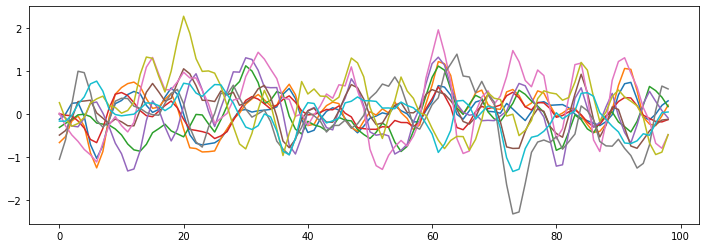

In [67]:
#create a multi-dimensional signal from filtered white noise
#here is the random number generator
from numpy.random import default_rng
from numpy import linalg as LA

rng = default_rng()
nTimes = 1000
nDims = 10
FIR_filter = [1,2,3,2,1]   # put some time-domain smoothing here
FIR_filter = FIR_filter / np.sum(FIR_filter)

#first, produce a smoothed set of independent random channels
sim_data = np.zeros((nTimes,nDims))
for d in range(0,nDims):
  random_signal = rng.standard_normal(nTimes)  #standard gaussian mean =0 std = 1
  filtered_signal = np.convolve(random_signal, FIR_filter, 'same') 
  sim_data[:,d] = filtered_signal   #one-dimensional slightly smoothed noise on each channel
sim_data /= sim_data.std()  #this now has nDims channels, each independent of the others.

#now introduce some correlations
random_matrix = rng.standard_normal((nDims,nDims))
random_matrix += random_matrix.T
w,v = LA.eig(random_matrix) #find the eigenvectors the easy way
w_new = np.ones(nDims) * 0.1    #background noise of level 0.1 on all channels
w_new[0] = 1.0;     # change the first 4 eigenvalues to be much larger; this creates correlations
w_new[1] = 0.9;
w_new[2] = 0.8;
w_new[3] = 0.7;
A = v @ np.diag(w_new) @ v.T   #reassemble with the altered eigenvalues.

#the following are equivalent
lowD_data = np.dot(sim_data,A)    #apply this to the independent data streams to generate a correlated signal
#weighted_random_data = w_new*sim_data
#lowD_data = weighted_random_data @ v.T

plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(lowD_data[1:100,0:10]);  #signals often rise and fall together.

array([1.06059772, 0.46482304, 0.6722392 , 0.79165552, 0.01124513,
       0.01087158, 0.01031063, 0.00848423, 0.00908184, 0.00902035])

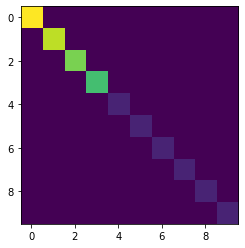

In [68]:
w1,v1=LA.eig(lowD_data.T @lowD_data/nTimes)  #just to be sure, find eigenvectors of Rxx
plt.imshow(v.T @A @v)  #these are the eigenvalues along the diagonal of the matrix.
w1   #these are the eigenvalues. should look like what we inserted

In [69]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping


Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 10)]          0         
                                                                 
 encode (Dense)              (None, 10, 4)             44        
                                                                 
 decode (Dense)              (None, 10, 10)            50        
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


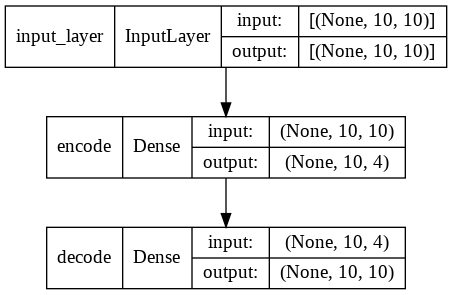

In [70]:
#build a simple linear autoencoder network
n_hidden_units = 4    #we know this should be 4; cheating but I want to show how it works.
batch_size = 10

input_layer = Input(shape=(batch_size, nDims), name='input_layer')
encode_layer = Dense(units=n_hidden_units, activation='linear', name='encode')(input_layer)
decode_layer = Dense(units=nDims, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

model1 = Model(inputs = input_layer, outputs = output_layer, name ='model1')  #have to explicitly tell it the inputs and outputs
model1.compile(optimizer='adam', loss='mse')
model1.summary()
plot_model(model1, show_shapes = True, show_layer_names = True)

These learn surprisingly slowly.  Partly because there is not really that much data. But this is much slower than the np.eig() function.  Where it has value is if you have 1,000,000 inputs, the np.eig() will choke trying to find all the eigenvectors, but an autoencoder network with 10 outputs will still find the first 10 eigenvectors.

Epoch 1/20
100/100 [==============================] - 0s 1ms/step - loss: 0.4280
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2139
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 0.1553
Epoch 5/20
100/100 [==============================] - 0s 1ms/step - loss: 0.1144
Epoch 6/20
100/100 [==============================] - 0s 2ms/step - loss: 0.0908
Epoch 7/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 8/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0756
Epoch 9/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0722
Epoch 10/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0677
Epoch 11/20
100/100 [==============================] - 0s 2ms/step - loss: 0.0604
Epoch 12/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0492
Epoch 13/20
100/100 [====

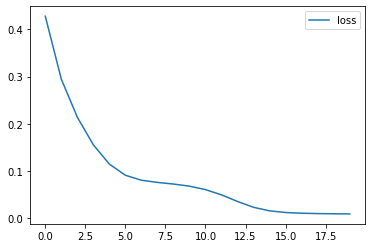

In [71]:
history = model1.fit(lowD_data, lowD_data, epochs = 20, batch_size = batch_size)
losses = pd.DataFrame(history.history)
losses.plot()

array([[ 0.82130936, -0.01717003,  0.08259187, -0.05329841],
       [ 0.00801237,  0.82237155,  0.06159556, -0.1453603 ],
       [ 0.04799949,  0.01115377,  0.84164629,  0.02911839],
       [-0.00179914, -0.11836615,  0.04027292,  0.9023475 ]])

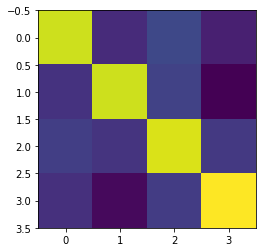

In [72]:
w_encode = np.asarray(model1.weights[0])  #look at the encoder weights
w_decode = np.asarray(model1.weights[2])  #and the decoder weights
plt.imshow(w_decode @ A @ w_encode);    #these should diagonalize the autocorrelation matrix
w_decode @ A @ w_encode   #diagonals should give the eigenvalues

#Model 2

The last model used all linear units.  Here I'm going to use a hidden layer that is softmax.  Remember that softmax is good for classification, so an autoencoder with a softmax hidden layer will tend to find clusters rather than dimensions.  If the hidden layer were a "hardmax" (forcing a one-hot representation) the network would be constrained to find clusters; that would be the best it could do.  Softmax does allow some cheating, but mostly it will do the right thing.

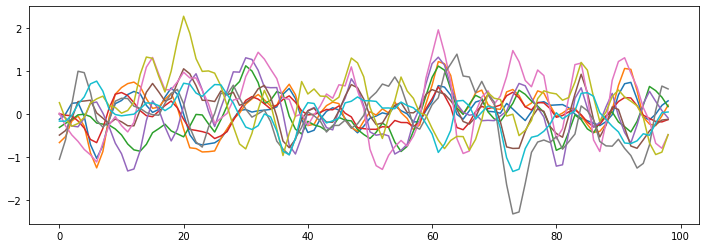

In [73]:
from tensorflow.keras.utils import to_categorical

norm_data = sim_data[:,1] - sim_data[:,1].min()  #use the first dimension to define the different classes changing smoothly
class_value = (3.99 * norm_data / norm_data.max())  #from 0 to 3.99 will give 4 classes
class_value = class_value.astype(int)   #classes are discrete
cat_data = np.zeros((nTimes,nDims))     #going to have 10 dimensions total, just like before
cat_data[:,0:4] = to_categorical(class_value)   #first 4 dimensions are the class memberships (one-hot)
cat_data += 0.1 * rng.standard_normal((nTimes, nDims))  #add noise to everything
lowCat_data = cat_data @ v.T;    #and mix things up using the eigenvectors. each class gets an eigenvector, plus noise
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(lowD_data[1:100,0:10]);  #hard to see the clusters here.

array([0.54969061, 0.35387567, 0.10224267, 0.03285456, 0.00836504,
       0.01100531, 0.01081945, 0.00997494, 0.00946807, 0.00931005])

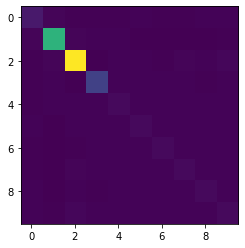

In [74]:
B = lowCat_data.T @lowCat_data/nTimes
w2,v2=LA.eig(B)
plt.imshow(v.T @ B @ v)  #get the classes back by inverting the eigenvector transformation
w2  #eigenvalues of the data matrix

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 10)]          0         
                                                                 
 encode (Dense)              (None, 10, 4)             44        
                                                                 
 decode (Dense)              (None, 10, 10)            50        
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


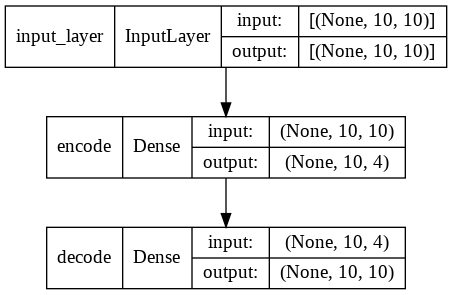

In [75]:
#build a simple autoencoder network with a categorical/softmax hidden layer
n_hidden_units = 4
batch_size = 10

input_layer = Input(shape=(batch_size, nDims), name='input_layer')
encode_layer = Dense(units=n_hidden_units, activation='softmax', name='encode')(input_layer)
decode_layer = Dense(units=nDims, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

model2 = Model(inputs = input_layer, outputs = output_layer, name ='model1')  #have to explicitly tell it the inputs and outputs
model2.compile(optimizer='adam', loss='mse')  #still using mse, because this is an autoencoder
model2.summary()
plot_model(model2, show_shapes = True, show_layer_names = True)

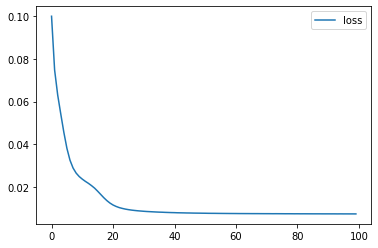

In [76]:
history = model2.fit(lowCat_data, lowCat_data, epochs = 100, batch_size = batch_size, verbose=0)
losses = pd.DataFrame(history.history)
losses.plot()

array([[-1.62759346,  0.18457503, -0.1219808 ,  0.61233114,  0.79036016,
        -0.31277055, -1.06113286,  0.09847414, -0.47423326, -0.11936421],
       [ 0.19622564,  0.79635735, -0.79506349, -0.27988324,  0.16709451,
        -0.21764339,  0.80621643, -0.26070471, -1.0528912 ,  1.86477206],
       [-0.32669749, -0.07138134,  0.75912672,  0.49537331, -0.36185776,
         0.44747394,  0.90005868,  0.72180533,  0.86531518, -0.19109   ],
       [ 0.94280146, -0.04510047, -0.9351411 , -0.25893463, -0.11202005,
         0.41234596, -0.12297442, -0.50437338, -0.24758248, -0.82509687]])

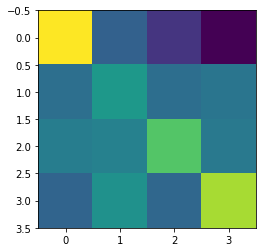

In [77]:
w_encode2 = np.asarray(model2.weights[0])
w_decode2 = np.asarray(model2.weights[2])
plt.imshow(w_decode2 @ B @ w_encode2);  #how well does autoencoder recover the original input
w_decode2 @ v.T

array([[  0.,   0., 542.,   0.],
       [ 23.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  89.],
       [  0., 346.,   0.,   0.]], dtype=float32)

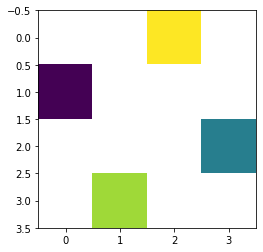

In [78]:
codes = lowCat_data @ w_encode2  #find the codes that were generated at the hidden layer
dfCodes1 = pd.DataFrame(codes)
predict1 = dfCodes1.idxmax(axis=1)   #use maximum likelihood to decode
confusion_matrix = to_categorical(predict1).T @ to_categorical(class_value)  #how well does it find the original classes
dfCM = pd.DataFrame(confusion_matrix).T
permute = dfCM.idxmax(axis=1).values   #it does not have to assign class 1 to the first hidden unit. may be permuted
permute = permute.T
plt.imshow(np.log(confusion_matrix))  #how well did it separate classes at the hidden layer
confusion_matrix

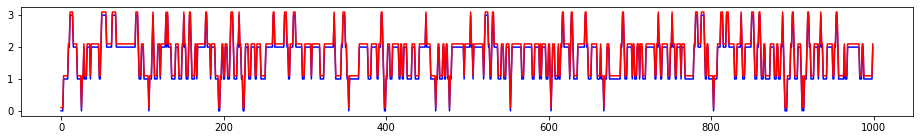

In [79]:

dfCodes = pd.DataFrame(codes[:,permute])   #now we need to permute to try to line these up for plotting
predict = dfCodes.idxmax(axis=1)
plt.figure(figsize = (16,2))    #compare the correct codes to the estimated codes
plt.plot(class_value,'b')
plt.plot(predict+0.1,'r');

#Model 3: nonlinear encoding/decoding

In this case, the data lie on a low-dimensional space, but it is not a linear space.  Because of the curature, a linear model won't work (it will try to fit a line and will have an awful time of it).  But if we use a nonlinear autoencoder, it can find nonlinear relationships between variables, including the possibility of curved surfaces.

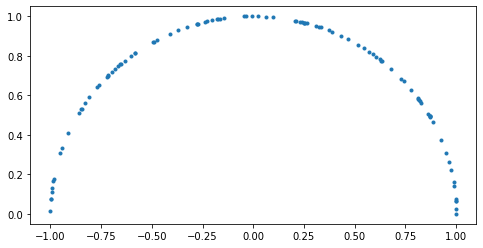

In [80]:
npoints = 100
theta = np.pi * rng.random(npoints)  #original data are one dimensional
data_x = np.cos(theta).reshape(npoints,1)  #embed them in a two dimensional space along a half-circle
data_y = np.sin(theta).reshape(npoints,1)
halfcircle_data = np.hstack([data_x,data_y])  #x,y coordinates of each point
plt.figure(figsize=(8,4))
plt.plot(data_x,data_y,'.');

First let's try a linear network to see what happens

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 encode (Dense)              (None, 1)                 3         
                                                                 
 decode (Dense)              (None, 2)                 4         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


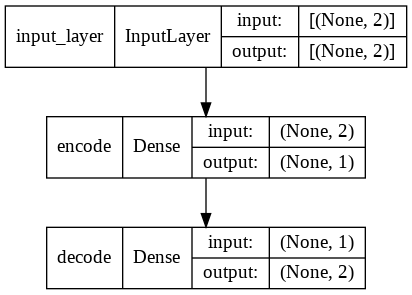

In [81]:
#build a simple autoencoder network for 2D data
n_hidden_units = 1
batch_size = 1

input_layer = Input(shape=(2), name='input_layer')
encode_layer = Dense(units=n_hidden_units, activation='linear', name='encode')(input_layer)
decode_layer = Dense(units=2, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

model3 = Model(inputs = input_layer, outputs = output_layer, name ='model3')  #have to explicitly tell it the inputs and outputs
model3.compile(optimizer='adam', loss='mse')
model3.summary()
plot_model(model3, show_shapes = True, show_layer_names = True)

In [82]:
model3.fit(halfcircle_data,halfcircle_data,epochs=100, verbose=0);

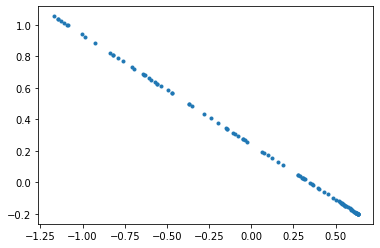

In [83]:
halfcircle_predict = model3.predict(halfcircle_data)
plt.plot(halfcircle_predict[:,0], halfcircle_predict[:,1],'.');  #awful, as expected

We didn't expect that to work. Now we will do the same thing using a nonlinear encoder.  You do not get more power using multiple layers in a linear network, but you do get more power from multiple layers when there are nonlinearities.  I will use two nonlinear layers to find a good representation (presumably the sin or cosine) and then a linear layer to find the hidden 1D encoding.   The same in reverse for the decoder.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 2)]               0         
                                                                 
 encoder (Functional)        (None, 1)                 6801      
                                                                 
 decoder (Functional)        (None, 2)                 6802      
                                                                 
Total params: 13,603
Trainable params: 13,603
Non-trainable params: 0
_________________________________________________________________


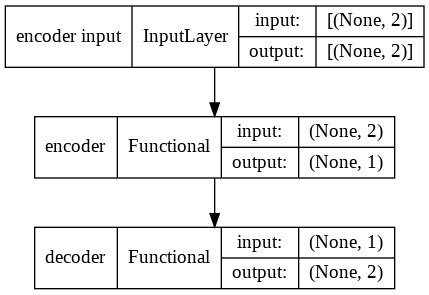

In [84]:
#build a simple autoencoder network for 2D data using a nonlinear encoder/decoder
n_hidden_units = 80
batch_size = 1

#using the functional API so that I can separate the encoder and decoder
encode_input = Input(shape=(2), name='encoder input')
encode_layer1 = Dense(units=n_hidden_units, activation='relu', name='encode1')(encode_input)
encode_layer2 = Dense(units=n_hidden_units, activation='relu', name='encode2')(encode_layer1)
encode_layer3 = Dense(units=1, activation='linear', name='encode3')(encode_layer2)
encode_output = encode_layer3
encoder4 = Model(encode_input,encode_output, name='encoder')  #separate model for the encoder
   # we can throw out the rest of the network after training if we want.

decode_input = Input(shape = (1))  #this is the same as the encoder output
decode_layer3 = Dense(units=n_hidden_units, activation='relu', name='decode3')(decode_input)
decode_layer2 = Dense(units=n_hidden_units, activation='relu', name='decode2')(decode_layer3)
decode_layer1 = Dense(units=2, activation='linear', name='decode1')(decode_layer2)
decode_output = decode_layer1
decoder4 = Model(decode_input, decode_output, name='decoder')  #model for the decoder

#build the stacked model
hidden_units = encoder4(encode_input)
full_output = decoder4(hidden_units)
model4 = Model(encode_input, full_output)  #this is the one we will train

#model4 = Model(inputs = input_layer, outputs = output_layer, name ='model4')  #have to explicitly tell it the inputs and outputs
model4.compile(optimizer='adam', loss='mse')
model4.summary()
plot_model(model4, show_shapes = True, show_layer_names = True)

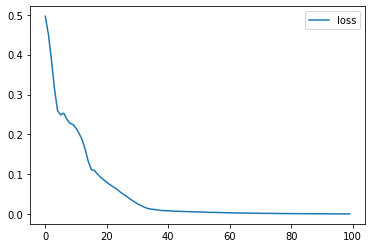

In [85]:
model4.fit(halfcircle_data,halfcircle_data,epochs=100, verbose=0);
losses = pd.DataFrame(model4.history.history)
losses.plot();

In [86]:
halfcircle_predict = model4.predict(halfcircle_data)

Nonlinear network did much better.

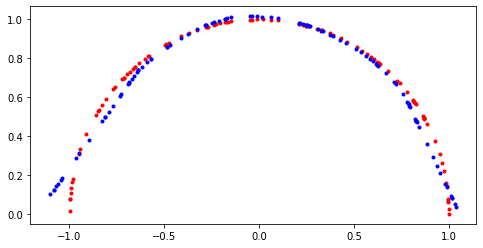

In [87]:

plt.figure(figsize=(8,4))
plt.plot(halfcircle_data[:,0], halfcircle_data[:,1],'r.');
plt.plot(halfcircle_predict[:,0], halfcircle_predict[:,1],'b.');

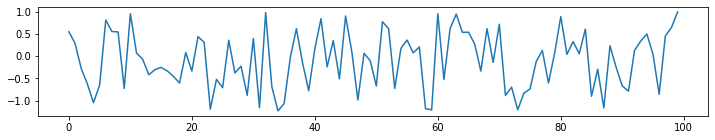

In [88]:
#use just the encoder network to find the hidden values over time.
#  this is what you would do if you wanted to calculate something from the low dimensional representation
hidden_values = encoder4.predict(halfcircle_data)
plt.figure(figsize=(12,2))
plt.plot(hidden_values);

Now we will use just the decoder to see what happens if we choose the hidden unit values.  This is a "generative model" in the sense that we produce data that look like the input in response to random or structured input that we provide.

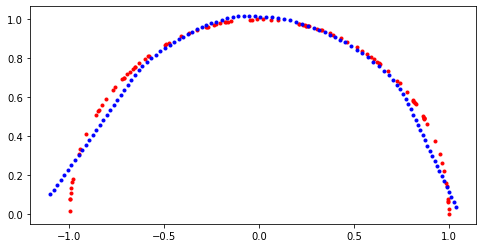

In [89]:
test_points = np.linspace(hidden_values.min(),hidden_values.max(),npoints)  #just use evenly spaced data with same range
halfcircle_predict2 = decoder4.predict(test_points.reshape(npoints,1))   #run through the decoder
#halfcircle_predict2 = decoder4.predict(hidden_values)
plt.figure(figsize=(8,4))
plt.plot(halfcircle_data[:,0], halfcircle_data[:,1],'r.');
plt.plot(halfcircle_predict2[:,0], halfcircle_predict2[:,1],'b.');
